In [1]:
%matplotlib inline
import collections
import sys
import subprocess
import pandas as pd
import os
import numpy as np
import uuid
import tempfile
import bnpy
import scikit_posthocs as sp
import itertools
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import kruskal, f_oneway
from scipy.stats import ttest_ind

sys.path.append('/opt/hydra/')

src = os.environ["HYDRA_SRC"]

import library.analysis as hy
import library.fit as ft

In [2]:
mm_genes = '../data/TH-OSTEO-MINUS-TARGET/MultiModalGenes/'
exp_path = '../data/TH-OSTEO-MINUS-TARGET.tsv'

In [3]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

In [4]:
exp.shape

(15528, 106)

In [5]:
if False:

    scan = hy.ScanEnrichmentAnalysis(mm_genes, 
                                     exp_path, 
                                     'GO', 
                                     min_prob_range=np.linspace(0.1, 0.3, 25), 
                                     CPU=7,
                                     K=5).scan()
    
    scan

In [6]:
res = hy.EnrichmentAnalysis(exp_path=exp_path,
                            mm_path=mm_genes,
                            min_prob_filter=0.266667,
                            gmt_path='GO')

In [7]:
res.get_enriched_terms()

,Unnamed: 0,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
0,GO:0006958,GO:0006958,"complement activation, classical pathway",24/295,74/11850,7.231908e-21,2.088575e-17,1.959467e-17,IGHV3-15/IGHG3/IGKV1D-39/IGKV3-15/IGHV3-7/IGLV...,24
1,GO:0006171,GO:0006171,cAMP biosynthetic process,8/295,63/11850,1.582080e-04,1.044109e-02,9.795658e-03,LTB4R2/NPR3/UCN2/GIPR/MARCO/ADCY2/PTHLH/EDN1,8


In [8]:
genes = res.get_enriched_term_genes()

len(genes)

32

In [9]:
clus = hy.MultivariateMixtureModel(data=exp.reindex(genes),
                                   center=True,
                                   gamma=5.0,
                                   variance=2.0,
                                   K=5, 
                                   verbose=True)

In [10]:
clus.fit()

centering data


In [11]:
help(bnpy.ioutil.ModelWriter.save_model)

Help on function save_model in module bnpy.ioutil.ModelWriter:

save_model(hmodel, outputdir, prefix, doSavePriorInfo=True, doSaveObsModel=True, doLinkBest=False)
    Saves HModel object to .mat format file on disk.
    
    Parameters
    --------
    hmodel: bnpy.HModel
    outputdir: str
        Absolute full path of directory to save in
    prefix: str
        Prefix for file name, like 'Lap0055.000' or 'Best'
        See makePrefixForLap function.
    doSavePriorInfo: boolean
        if True, save parameters that define model prior to disk.
    doSaveObsModel : boolean
        if True, save global params that define observation model.
    doLinkBest : boolean
        if True, copy saved global parameter files under prefix 'Best'
        This allows rapid access of the most recent (best) parameters.
    
    Post Condition
    --------
    outputdir defines a valid directory on disk.
        If it doesn't exist at first, this directory will be created.
    File outputdir/<prefix>Al

In [12]:
bnpy.ioutil.ModelWriter.save_model(clus.hmodel, 
                                   outputdir="EnrichmentAnalysisV1",
                                   prefix="EnrichmentAnalysisV1")

In [13]:
clus.og_data.to_csv("training-data.tsv", sep='\t')

In [14]:
exp.reindex(clus.clusters[0], axis=1).to_csv('../data/TREE-osteo-Cluster-0.tsv', sep='\t')

In [15]:
assignments = clus.get_assignments(exp.reindex(genes))

assign = pd.DataFrame(index=exp.columns,
                      columns=[1])

for sample, assignment in zip(exp.columns, assignments):
    assign.loc[sample, 1] = assignment + 1

In [16]:
hclust = hy.HClust(data=exp.reindex(genes))

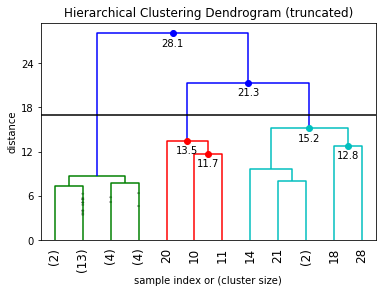

In [17]:
hclust.plot_row_linkage(17)
row_groups = hclust.get_row_groups(17)

In [18]:
sns.color_palette("Set2", max(assign[1].values))

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

In [19]:
assign.sort_values(1)[1].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

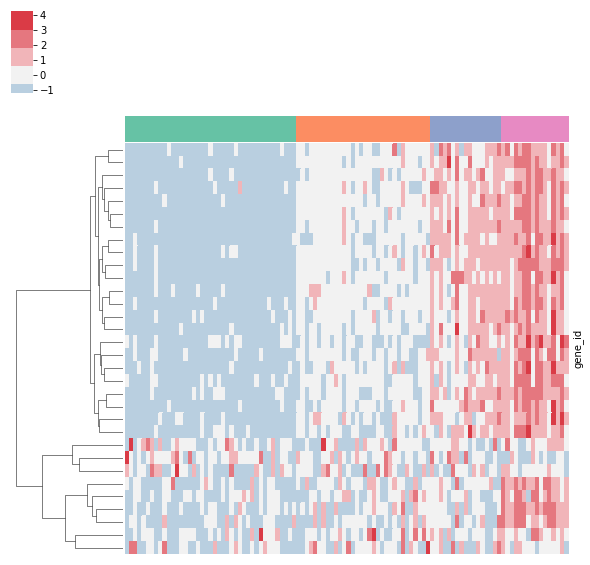

In [20]:
col_order = assign.sort_values(1).index.values
cmap = sns.color_palette("Set2", max(assign[1].values))
col_colors = [cmap[x - 1] for x in assign.sort_values(1)[1].values]

g = sns.clustermap(exp.reindex(genes).reindex(col_order, axis=1),
                   col_cluster=False,
                   col_colors=col_colors,
                   z_score=0,
                   method='ward',
                   center=0,
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

pth = '../img/expression-heatmap.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/expression-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [21]:
fgsea = clus.get_cluster_features(exp, 
                                  gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

In [29]:
fgsea[3]

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
PROTEIN ACTIVATION CASCADE%GOBP%GO:0072376,0.000074,0.007032,0.732988,3.263943,0,48,FCN3|C7|IGHV3-74|IGKV1-12|IGHV3-21|IGHA1|IGKV4...
COMPLEMENT ACTIVATION%GOBP%GO:0006956,0.000077,0.007032,0.772282,3.221061,0,36,FCN3|C7|IGHV3-74|IGKV1-12|IGHV3-21|IGHA1|IGKV4...
"COMPLEMENT ACTIVATION, CLASSICAL PATHWAY%GOBP%GO:0006958",0.000082,0.007032,0.821630,2.977169,0,21,IGHV3-74|IGKV1-12|IGHV3-21|IGHA1|IGKV4-1|IGHV3...
HUMORAL IMMUNE RESPONSE%GOBP%GO:0006959,0.000069,0.007032,0.571761,2.938796,0,111,SFTPD|PLA2G1B|FCN3|C7|IGHV3-74|IGKV1-12|CXCL2|...
"PHAGOCYTOSIS, RECOGNITION%GOBP%GO:0006910",0.000085,0.007032,0.855154,2.912124,0,17,FCN3|IGHV3-74|IGHV3-21|IGHA1|IGHV3-15|IGHV4-61...
HUMORAL IMMUNE RESPONSE MEDIATED BY CIRCULATING IMMUNOGLOBULIN%GOBP%GO:0002455,0.000081,0.007032,0.765680,2.877916,0,24,IGHV3-74|IGKV1-12|IGHV3-21|IGHA1|IGKV4-1|IGHV3...
INITIAL TRIGGERING OF COMPLEMENT%REACTOME DATABASE ID RELEASE 66%166663,0.000082,0.007032,0.755911,2.772509,0,22,FCN3|IGKV1-12|IGKV4-1|IGKV3-11|IGKV2-28|C4B|IG...
COMPLEMENT CASCADE%REACTOME DATABASE ID RELEASE 66%166658,0.000076,0.007032,0.651022,2.751612,0,38,C4BPA|FCN3|C7|IGKV1-12|IGKV4-1|IGKV3-11|C5|IGK...
ADAPTIVE IMMUNE RESPONSE BASED ON SOMATIC RECOMBINATION OF IMMUNE RECEPTORS BUILT FROM IMMUNOGLOBULIN SUPERFAMILY DOMAINS%GOBP%GO:0002460,0.000071,0.007032,0.565511,2.747027,0,76,IGHV3-74|IGKV1-12|IGHV3-21|IGHA1|IGKV4-1|IGHV3...


In [22]:
mkdir features/3

mkdir: cannot create directory ‘features/3’: No such file or directory


In [23]:
for key, value in fgsea.items():
    value.to_csv("features/%d/cluster-%d-GSEA.tsv" % (key, key))

IOError: [Errno 2] No such file or directory: 'features/0/cluster-0-GSEA.tsv'

In [ ]:
def format_pathway(x):
    fields = x.split('%')
    return '%s (%s)' % (fields[0], fields[1])

pth = '../img/TREE-top-10-pathways-cluster-%d.tex'
for key, values in fgsea.items():
    with pd.option_context('display.precision', 2):
        t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
        t['pathway'] = t['pathway'].apply(format_pathway)
        with open(pth % key, 'w') as f:
            print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(index=False))
            t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(f, index=False)

In [ ]:
fgsea_df = None
for key, values in fgsea.items():
    if fgsea_df is None:
        header = pd.MultiIndex.from_product([list(fgsea.keys()), 
                                             ['padj', 'NES']],
                                           names=['cluster', 'feature'])
        
        fgsea_df = pd.DataFrame(index=values.index.values, columns=header)
        
    print 'Key: ', key,
    t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
    t['pathway'] = t['pathway'].apply(format_pathway) 
    print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10))
    
    fgsea_df[(key, 'padj')] = values.loc[fgsea_df.index, 'padj'].values
    fgsea_df[(key, 'NES')] = values.loc[fgsea_df.index, 'NES'].values

In [ ]:
pth = '../data/TH-Osteo-Pathways-Enrichment.tsv'
fgsea_df.to_csv(pth, sep='\t')

In [ ]:
if False:
    for sample in exp.columns:
        r = clus.sub_cluster_gsea(exp[sample],
                                  gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')
    
        sigs = r[1][(r[1]['ES'] > 0) & (r[1]['padj'] < 0.05) & (r[1]['size'] > 1)].sort_values('padj')
    
        if len(sigs) > 0:
            print(sample, r[0])
            print(sigs)

In [ ]:
def get_event(event):
    if pd.isnull(event):
        print("NULL")
        return np.nan
    
    events = ['Relapse',
              'Death', 
              'Progression',
              'Event',
              'Second Malignant Neoplasm',
              'SMN']
    
    if event in ['Censored', 'No event', 'None']:
        return 0
    
    elif event in events:
        return 1 
    
    else:
        raise ValueError(event)
        
def get_vital(vital):
    if pd.isnull(vital):
        #print("NULL")
        return np.nan
    
    
    if vital == 'Alive':
        return 0
    
    elif vital == 'Dead':
        return 1
    
    else:
        raise ValueError(vital)

pth = '../../without-muscle/data/TARGET_OS_ClinicalData_Discovery_20181009.xlsx'
clinical = pd.read_excel(pth, index_col=0)

surv = pd.DataFrame(index=test.columns, 
                    columns=['OS', 'vital', 'EFS', 'event'])

for sample in test.columns:
    root = '-'.join(sample.split('-')[:3])
    if root not in clinical.index:
        print "Missing: ", sample
        continue
    
    OS = clinical.loc[root, 'Overall Survival Time in Days'].item()
    vital = get_vital(clinical.loc[root, 'Vital Status'])
    
    EFS = clinical.loc[root, 'Event Free Survival Time in Days'].item()
    #print(repr(clinical.loc[root, 'First Event']))
    event = get_event(clinical.loc[root, 'First Event'])
    
    surv.loc[sample, :] = [OS, vital, EFS, event]
    

for sample in test.columns:
    surv.loc[sample, 'cluster'] = int(test_assign.loc[sample, 'cluster'])
    
#surv = surv[surv['cluster'].isin([2.0, 3.0])]

surv = surv.dropna()
    
surv.to_csv('../data/TARGET-osteo-TH-assignment-survival.tsv', sep='\t')

surv